In [17]:
# all needed installation are done
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import tensorflow as tf
import keras
from keras import layers

####  Phase 1: Load the data

In [18]:
df = pd.read_csv("housing_before_optimization.csv")
df.head()

,housing_median_age,total_rooms,population,median_income,median_house_value,distance_to_nearest_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
0,41.0,880.0,322.0,8.3252,452600.0,20.33,0,0,0,1
1,21.0,7099.0,2401.0,8.3014,358500.0,19.91,0,0,0,1
2,52.0,1467.0,496.0,7.2574,352100.0,17.84,0,0,0,1
3,52.0,1274.0,558.0,5.6431,341300.0,17.06,0,0,0,1
4,52.0,1627.0,565.0,3.8462,342200.0,17.06,0,0,0,1


####  X/y + train/test -splits + other data setups

In [19]:
df.describe()

,housing_median_age,total_rooms,population,median_income,median_house_value,distance_to_nearest_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,28.633094,2636.504233,1424.946949,3.871162,206864.413155,89.803481,0.442128,0.317917,0.000245,0.111095
std,12.591805,2185.269567,1133.208490,1.899291,115435.667099,84.324286,0.496652,0.465678,0.015641,0.314257
min,1.000000,2.000000,3.000000,0.499900,14999.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1450.000000,787.000000,2.563700,119500.000000,22.810000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,2127.000000,1166.000000,3.536500,179700.000000,57.990000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,3143.000000,1722.000000,4.744000,264700.000000,140.190000,1.000000,1.000000,0.000000,0.000000
max,52.000000,39320.000000,35682.000000,15.000100,500001.000000,489.120000,1.000000,1.000000,1.000000,1.000000


In [20]:
df.columns

Index(['housing_median_age', 'total_rooms', 'population', 'median_income',
       'median_house_value', 'distance_to_nearest_city',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY'],
      dtype='str')

In [21]:
# CatBoost requires we save our continuous and categorical variables separately into lists
categorical_variables = [ 
    "ocean_proximity_<1H OCEAN",
    "ocean_proximity_INLAND",
    "ocean_proximity_ISLAND",
    "ocean_proximity_NEAR BAY"]

# continuous variables also into a list
continuous_variables = [ 
    "housing_median_age",
    "total_rooms",
    "population",
    "median_income",
    "distance_to_nearest_city",
    "median_house_value"]

# the usual X/y -split
X = df.drop("median_house_value", axis=1)
y = df['median_house_value']

# usual train/test -split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# NOTE! SCALING => some of the algorithms require this
scaler = StandardScaler()

# create separate versions for the scaled data
# because we need both unscaled and scaled versions later
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

####  List all models that we want to benchmark

In [22]:
# define our model test dictionary

# our data has 17 697 rows, so it is not a huge dataset.

# RandomizedSearchCV results LightGBM:
# Best parameters from RandomizedSearchCV: {'learning_rate': np.float64(0.10911764705882354), 'max_depth': 10, 'num_leaves': 46}

models = {
    "Linear Regression": LinearRegression(),
    "SVM": SVR(),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor(enable_categorical=True, objective="reg:squarederror"),
    "CatBoost": cb.CatBoostRegressor(verbose=0),
    'LightGBM-default': lgb.LGBMRegressor(objective='regression'),
    #'LightGBM-opt': lgb.LGBMRegressor(objective='regression', learning_rate=0.10426470588235295, max_depth=8, num_leaves=40),
}

####  We need a for-loop to train all the models in one go + gather metrics

In [23]:
# our benchmarking code!

# this will contain our results later after the benchmarks
results = []

# loop through the models
for name, model in models.items():
    # we have to react to certain algorithms
    # because they have special requirements for fit()

    print("Starting..." + name)

    # SVM / KNN require scaled data
    if name in ["SVM", "KNN"]:
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
    elif name == "CatBoost":
        # CatBoost requires we specify which columns are categories
        # this includes both ordinal and nominal categories
        model.fit(X_train, y_train, cat_features=categorical_variables)
        predictions = model.predict(X_test)
    else:
        # all the other algorithms
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

    # after training this particular algorithm, gather the metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # save the metrics for this model into the results
    results.append([name, mae, mse, rmse, r2])

Starting...Linear Regression
Starting...SVM
Starting...KNN
Starting...Random Forest
Starting...XGBoost
Starting...CatBoost
Starting...LightGBM-default
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 8
[LightGBM] [Info] Start training from score 207326.078123


####  Let's visualize the results

In [24]:
metrics_df = pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

# change these highlight colors as you wish
# default style is dart theme / mode, modify
# variable default_highlight_style if you wish 
# to use light theme instead
light_theme = 'background: yellow'
dark_theme = 'background: #8C670A'

# you can alternate the highlight styling based on your theme
default_highlight_style = dark_theme

# helper function that highlights the best model of each metric
def highlight_best_metrics(row):
    # default styles for everything is empty in the beginning
    styles = ['' for _ in row]

    # index 1 => MAE (index 0 => model name)
    if row['MAE'] == metrics_df['MAE'].min():
        styles[1] = default_highlight_style

    # index 2 = > MSE
    if row['MSE'] == metrics_df['MSE'].min():
        styles[2] = default_highlight_style

    # index 3 = > RMSE
    if row['RMSE'] == metrics_df['RMSE'].min():
        styles[3] = default_highlight_style

    # index 4 = > R-squared (R2)
    if row['R2'] == metrics_df['R2'].max():
        styles[4] = default_highlight_style

    return styles


# apply the custom styles based on the min/max metrics
highlight_df = metrics_df.style.apply(highlight_best_metrics, axis=1)


highlight_df

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,50614.229584,4823017253.423055,69447.946359,0.633843
1,SVM,87462.002125,13634706978.006037,116767.748021,-0.035128
2,KNN,42666.202251,4020624533.468863,63408.394819,0.694760
3,Random Forest,39973.245804,3476416174.500656,58961.141225,0.736075
4,XGBoost,38474.133326,3282958641.993272,57297.108496,0.750762
5,CatBoost,37247.527849,2993040252.624354,54708.685349,0.772773
6,LightGBM-default,38004.516949,3113783874.993344,55801.289188,0.763606


#### results using following parameters: Best parameters from RandomizedSearchCV: {'learning_rate': np.float64(0.10911764705882354), 'max_depth': 10, 'num_leaves': 46}


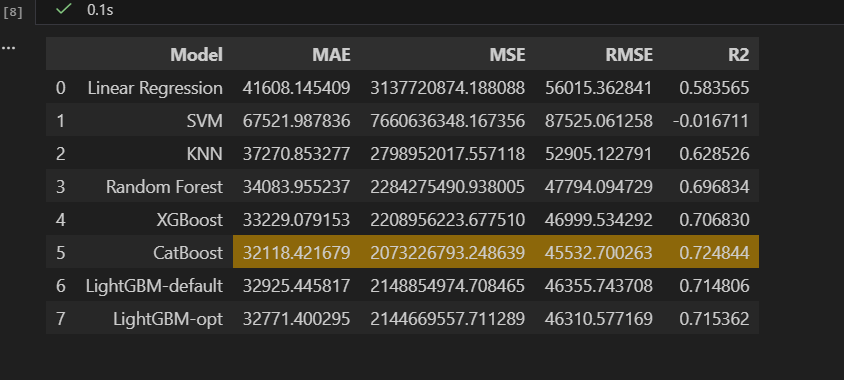
#### results without dropping rows of median_house_value that are more than 500 001, using parameters: Best parameters from RandomizedSearchCV: {'learning_rate': np.float64(0.10426470588235295), 'max_depth': 17, 'num_leaves': 42}
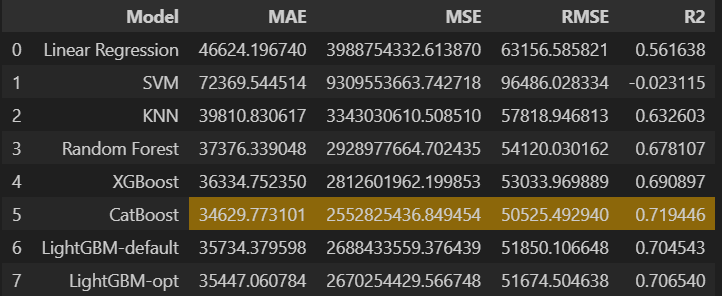
#### results before optimizing dataset with RANSAC + MAD + Isolation Forest using "housing_before_optimization.csv", Best parameters from RandomizedSearchCV: {'learning_rate': np.float64(0.1103448275862069), 'max_depth': 8, 'num_leaves': 44}
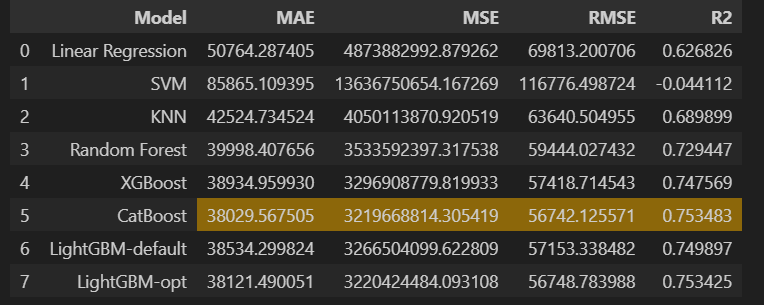